In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Labelled Data

In [4]:
df = pd.read_csv("df_all_labeled_clean.csv")
df["clean_text"] = df["clean_text"].astype(str)
texts = df["clean_text"].tolist()

label_map = {"Neutral":0, "Inflation":1, "Deflation":2}
df["label_id"] = df["label"].map(label_map).astype(int)
df.head()

,url,domain,title,date,clean_text,label,label_reason,source,year_month,year,month,tokens,text_len,label_id
0,https://market.bisnis.com/read/20200629/235/12...,market.bisnis.com,"Harga Emas Semakin Dekati US$1.800, Level Tert...",2020-06-29,Harga emas berjangka semakin mendekati level U...,Neutral,Kenaikan harga emas adalah tentang aset invest...,bisnis,2020-06,2020,6,426,3000,0
1,https://market.bisnis.com/read/20200826/93/128...,market.bisnis.com,Mantap! Rupiah Menguat Saat Mayoritas Mata Uan...,2020-08-26,Nilai tukar rupiah terhadap dolar Amerika Seri...,Deflation,Penguatan nilai tukar rupiah membuat harga bar...,bisnis,2020-08,2020,8,299,2072,2
2,https://market.bisnis.com/read/20200831/94/128...,market.bisnis.com,"Selain Emas, Harga Minyak Juga Terbantu Lesuny...",2020-08-31,Harga minyak mengalami penguatan seiring denga...,Inflation,Kenaikan harga minyak merupakan pendorong utam...,bisnis,2020-08,2020,8,188,1307,1
3,https://market.bisnis.com/read/20210910/235/14...,market.bisnis.com,"Naik Tipis! Harga Emas 24 Karat di Pegadaian, ...",2021-09-10,Harga emas batangan 24 karat yang dijual di Pe...,Neutral,Kenaikan harga emas batangan adalah tentang as...,bisnis,2021-09,2021,9,208,1465,0
4,https://market.bisnis.com/read/20200926/235/12...,market.bisnis.com,"Dolar AS Dinilai Lebih Aman, Harga Emas Jatuh",2020-09-26,Harga emas berjangka jatuh pada akhir pekan se...,Neutral,Penurunan harga emas berjangka mencerminkan pe...,bisnis,2020-09,2020,9,285,1938,0


Load the "Gold Standard" lables generated by the Teacher model (Gemini). Then it label mapped from categorical sentiment lables into integer format. Purpose integer incoding is necessary for tensor based operation and metric calculations.

In [ ]:
# model loader & batch predictor
def load_model(path):
    tok = AutoTokenizer.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path)
    model.eval()
    return tok, model

def predict_batch(texts, tok, model, batch=16):
    out_labels = []
    out_probs = []
    for i in range(0, len(texts), batch):
        chunk = texts[i:i+batch]
        enc = tok(
            chunk,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        with torch.no_grad():
            logits = model(**enc).logits
        probs = torch.softmax(logits, dim=1).numpy()
        preds = probs.argmax(axis=1)
        out_labels.extend(preds)
        out_probs.extend(probs)
    return np.array(out_labels), np.array(out_probs)

# model paths
paths = {
    "indobert": "model/indobert-base-p2/model",
    "indolem": "model/indolem-indobert-base-uncased/model",
    "mdeberta": "model/mdeberta-v3-base/model"
}

## Run Predictions & Save models

In [ ]:
preds = {}
probs = {}

for name, path in paths.items():
    tok, model = load_model(path)
    p, pr = predict_batch(texts, tok, model)
    preds[name] = p
    probs[name] = pr

for name in preds:
    df[f"label_{name}"] = preds[name]
    df[f"prob_{name}_0"] = probs[name][:,0]
    df[f"prob_{name}_1"] = probs[name][:,1]
    df[f"prob_{name}_2"] = probs[name][:,2]

df.to_csv("student_predictions_full.csv", index=False)

3 transformer based models (IndoBERT, IndoLEM, and mDeBERTa) are initialized in eval() mode. The evaluation mode is critical as it disables dropout layers, ensuring deterministic and reproducible probability outputs.

The predict_batch function processes text in batches (size 16) to manage GPU memory efficiency. It applies a softmax function to the raw model logits, converting them into a valid probability distribution that sums to 1.0. Finally, the script iterates through all three models, appending their specific probability vectors (prob_0, prob_1, prob_2) to the main dataframe.

The resulting dataframe contains where every single news article is associated with three distinct probability sets. This granularity is essential for constructing a robust index, instead of relying on a hard binary classification, the index can leverage the confidence of the model ("85% probability of Inflation"), allowing for a more nuanced measurement of economic sentiment.

# Load Student Model Predictions

In [5]:
df = pd.read_csv("student_predictions_full.csv")
df.head()

,url,domain,title,date,clean_text,label,label_reason,source,year_month,year,...,prob_indobert_1,prob_indobert_2,label_indolem,prob_indolem_0,prob_indolem_1,prob_indolem_2,label_mdeberta,prob_mdeberta_0,prob_mdeberta_1,prob_mdeberta_2
0,https://market.bisnis.com/read/20200629/235/12...,market.bisnis.com,"Harga Emas Semakin Dekati US$1.800, Level Tert...",2020-06-29,Harga emas berjangka semakin mendekati level U...,Neutral,Kenaikan harga emas adalah tentang aset invest...,bisnis,2020-06,2020,...,0.141268,0.127134,1,0.363242,0.528562,0.108196,0,0.816957,0.084440,0.098603
1,https://market.bisnis.com/read/20200826/93/128...,market.bisnis.com,Mantap! Rupiah Menguat Saat Mayoritas Mata Uan...,2020-08-26,Nilai tukar rupiah terhadap dolar Amerika Seri...,Deflation,Penguatan nilai tukar rupiah membuat harga bar...,bisnis,2020-08,2020,...,0.039476,0.819605,2,0.080423,0.012341,0.907235,2,0.083237,0.030638,0.886124
2,https://market.bisnis.com/read/20200831/94/128...,market.bisnis.com,"Selain Emas, Harga Minyak Juga Terbantu Lesuny...",2020-08-31,Harga minyak mengalami penguatan seiring denga...,Inflation,Kenaikan harga minyak merupakan pendorong utam...,bisnis,2020-08,2020,...,0.638360,0.327350,1,0.013783,0.933891,0.052326,1,0.030938,0.909928,0.059134
3,https://market.bisnis.com/read/20210910/235/14...,market.bisnis.com,"Naik Tipis! Harga Emas 24 Karat di Pegadaian, ...",2021-09-10,Harga emas batangan 24 karat yang dijual di Pe...,Neutral,Kenaikan harga emas batangan adalah tentang as...,bisnis,2021-09,2021,...,0.042916,0.069000,0,0.857471,0.073410,0.069120,0,0.801619,0.083546,0.114835
4,https://market.bisnis.com/read/20200926/235/12...,market.bisnis.com,"Dolar AS Dinilai Lebih Aman, Harga Emas Jatuh",2020-09-26,Harga emas berjangka jatuh pada akhir pekan se...,Neutral,Penurunan harga emas berjangka mencerminkan pe...,bisnis,2020-09,2020,...,0.125668,0.130126,0,0.626895,0.202571,0.170534,0,0.356771,0.318156,0.325073


# Load & Clean CPI Data

In [ ]:
# Load CPI Data
df_rate = pd.read_excel("M-to-M CPI Rate Indonesia 2017-2025 Clean.xlsx", sheet_name="Sheet1")

# Clean Rate Column
df_rate["Rate"] = df_rate["Rate"].astype(str).str.replace(",", ".", regex=False)
df_rate["Rate"] = df_rate["Rate"].replace(["-", ""], np.nan)
df_rate = df_rate.dropna()
df_rate["Rate"] = df_rate["Rate"].astype(float)

# Drop "Annually" rows
df_rate = df_rate[df_rate["Month"] != "Annually"].copy()

# Map Month Names to Numbers
month_map = {
    "January": "01", "February": "02", "March": "03", "April": "04", "May": "05", "June": "06",
    "July": "07", "August": "08", "September": "09", "October": "10", "November": "11", "December": "12"
}
df_rate["month_num"] = df_rate["Month"].map(month_map)

# Create year_month column for merging
df_rate["year_month"] = df_rate["Year"].astype(str) + "-" + df_rate["month_num"]
# Convert the string 'year_month' to datetime
df_rate["year_month"] = pd.to_datetime(df_rate["year_month"]) 
# Convert the datetime column to a Period[M] object to match cpi_clean
df_rate["year_month"] = df_rate["year_month"].dt.to_period("M")

# Select only needed columns
cpi_clean = df_rate[["year_month", "Rate"]].sort_values("year_month")
print("CPI Data Loaded. Shape:", cpi_clean.shape)

CPI Data Loaded. Shape: (106, 2)


In [ ]:
cpi_clean['year_month'].value_counts().sort_index()

year_month
2017-01    1
2017-02    1
2017-03    1
2017-04    1
2017-05    1
          ..
2025-06    1
2025-07    1
2025-08    1
2025-09    1
2025-10    1
Freq: M, Name: count, Length: 106, dtype: int64

Shape: (106, 2) confirms a clean dataset of 106 monthly observations. This time series serves as the "Ground Truth" target variable for all subsequent correlation and forecasting tests.

# Create Raw INSEI

In [6]:
# Ensure date column is datetime
df["date"] = pd.to_datetime(df["date"])
df["year_month"] = df["date"].dt.to_period("M")

def build_monthly_raw(df, model_name):
    d = df.copy()
    # Use probabilities (Soft Labels) to preserve uncertainty
    d["inflation_prob"] = d[f"prob_{model_name}_1"]
    d["deflation_prob"] = d[f"prob_{model_name}_2"]
    
    # Aggregate to monthly average
    monthly = d.groupby("year_month")[["inflation_prob", "deflation_prob"]].mean().reset_index()
    
    # Raw Index Calculation: Net Inflationary Pressure
    # Logic: If Infl > Defl, score is positive. If Defl > Infl, score is negative.
    monthly[f"insei_{model_name}_raw"] = monthly["inflation_prob"] - monthly["deflation_prob"]
    
    return monthly[["year_month", f"insei_{model_name}_raw"]]

# Special function for Gemini (since it uses hard labels 0/1/2 in your dataset)
def build_monthly_raw_gemini(df):
    d = df.copy()
    d["gem_inf"] = (d["label"] == "Inflation").astype(int)
    d["gem_def"] = (d["label"] == "Deflation").astype(int)
    # Calculating the mean per month
    monthly = d.groupby("year_month")[["gem_inf", "gem_def"]].mean().reset_index()
    # Gemini Raw = %Inflation - %Deflation
    monthly["insei_gemini_raw"] = monthly["gem_inf"] - monthly["gem_def"]
    return monthly[["year_month", "insei_gemini_raw"]]

# Build for all 3 models + Gemini (Teacher)
raw_indobert = build_monthly_raw(df, "indobert")
raw_indolem = build_monthly_raw(df, "indolem")
raw_mdeberta = build_monthly_raw(df, "mdeberta")
raw_gemini = build_monthly_raw_gemini(df)
# Merge into one dataframe
insei_df = raw_indobert.merge(raw_indolem, on="year_month").merge(raw_mdeberta, on="year_month").merge(raw_gemini, on ="year_month")
print("Raw Monthly Index Created. Shape:", insei_df.shape)

Raw Monthly Index Created. Shape: (106, 5)


In [7]:
insei_df['year_month'].value_counts().sort_index()

year_month
2017-01    1
2017-02    1
2017-03    1
2017-04    1
2017-05    1
          ..
2025-06    1
2025-07    1
2025-08    1
2025-09    1
2025-10    1
Freq: M, Name: count, Length: 106, dtype: int64

The construction of the Indonesian News Sentiment Economic Index (INSEI) follows a strict aggregation logic.

For a given month $t$, let $N_t$ be the set of news articles published in that month. For each article $i \in N_t$, the model generates probabilities for Inflation ($P_{inf}$) and Deflation ($P_{def}$).

The raw sentiment score $S_{i,t}$ for a single article is defined as the Net Inflationary Pressure:$$S_{i,t} = P(\text{Inflation})_{i,t} - P(\text{Deflation})_{i,t}$$

The aggregate monthly index $INSEI_t^{raw}$ is calculated as the mean of these net pressures:$$INSEI_t^{raw} = \frac{1}{|N_t|} \sum_{i=1}^{|N_t|} S_{i,t}$$

The build_monthly_raw function implements this formula. It aggregates the article-level probabilities by month and calculates the difference between the mean inflation probability and the mean deflation probability. 

A separate function build_monthly_raw_gemini applies a similar logic for the Teacher model using its hard labels. Finally, all four indices (IndoBERT, IndoLEM, mDeBERTa, and Gemini) are merged into a single dataframe insei_df.

Resulting (106,5) of shape indicating 1 time period and 4 multi index dataframe.

# Correlation Test (Raw)

Rate                  1.000000
insei_mdeberta_raw    0.351882
insei_indolem_raw     0.332299
insei_gemini_raw      0.316506
insei_indobert_raw    0.314582
Name: Rate, dtype: float64


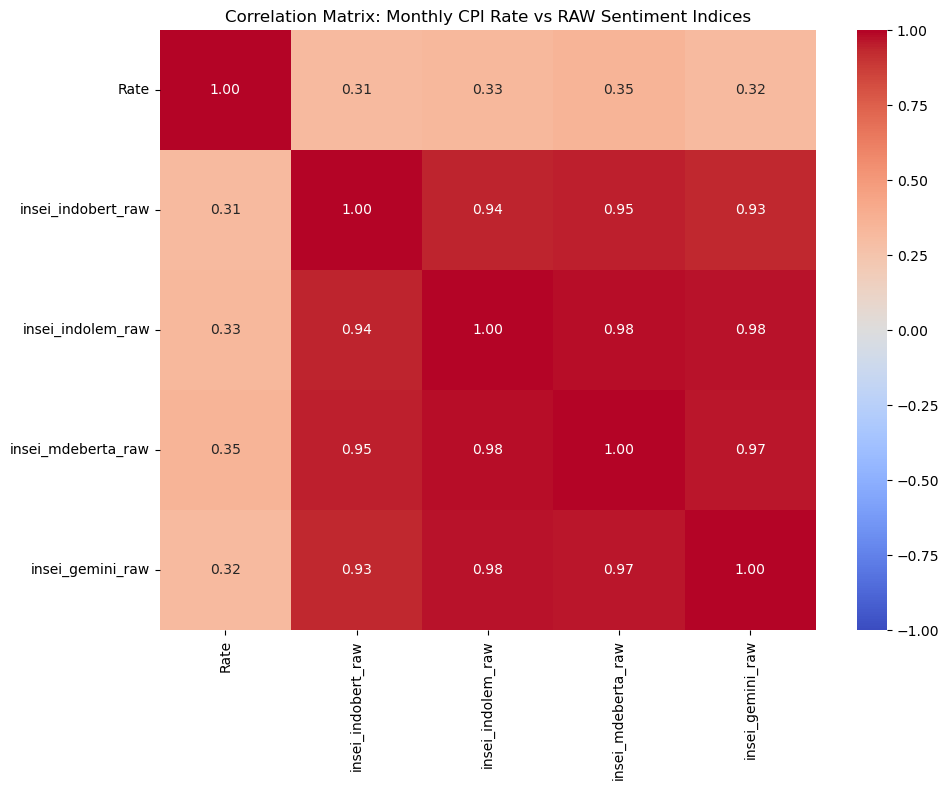

In [10]:
models = ["indobert", "indolem", "mdeberta", "gemini"]

# Create a temporary test dataframe
test_df = pd.merge(insei_df, cpi_clean, on="year_month", how="inner")
cols_to_check = ["Rate"] + [col for col in test_df.columns if "raw" in col]

# 2. Calculate Correlation
raw_corr_matrix = test_df[cols_to_check].corr()

# 3. Print specific correlation with Inflation Rate
print(raw_corr_matrix["Rate"].sort_values(ascending=False))

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(raw_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix: Monthly CPI Rate vs RAW Sentiment Indices')
plt.tight_layout()
plt.show()

A temporoarary test dataframe is created by merging the sentiment indexes and the CPI Rate.

Insight:
All four NLP models (IndoBERT, IndoLEM, mDeBERTa, and Gemini) exhibit extremely strong correlations with each other (0.97-0.99). This validates the robustness of the student models, despite architectural diffrences, they have successfully learned to mimic the teacher's logicvc and are captuiring the same underlying semantic signals.

But, the CPI correlation is moderate. The correlation between the sentiment indices and CPI Rate is but relatively weak (0.31-0.35). This is an expected result for raw, contemporaneous data. News sentiment is often "noisier" and reacts faster than official statistics. This low linear correlation justifies the need for the subsequent Granger Causality test to investigate predictive (lagged) relationships rather than just simultaneous movement.

# Granger Casuality Test

In [11]:
MAX_LAG = 12
TARGET_COL = "Rate"
results = {}

for model in models:
    predictor_col = f"insei_{model}_raw"
    gc_res = grangercausalitytests(test_df[[TARGET_COL, predictor_col]], maxlag=MAX_LAG)
    p_values = []
    for i in range(1, MAX_LAG + 1):
        p_val = gc_res[i][0]['ssr_chi2test'][1]
        p_values.append(p_val)
    
    results[model] = p_values

granger_df = pd.DataFrame(results, index=[f"Lag_{i}" for i in range(1, MAX_LAG + 1)]).T
best_lag_col = granger_df.mean().idxmin()
best_lag_value = int(best_lag_col.split("_")[1])

print(f"\n\nRecommended Lag based on lowest average p-value: {best_lag_value}")
print("\nGRANGER CAUSALITY P-VALUES")
granger_df


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1947  , p=0.1416  , df_denom=102, df_num=1
ssr based chi2 test:   chi2=2.2592  , p=0.1328  , df=1
likelihood ratio test: chi2=2.2353  , p=0.1349  , df=1
parameter F test:         F=2.1947  , p=0.1416  , df_denom=102, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8460  , p=0.0246  , df_denom=99, df_num=2
ssr based chi2 test:   chi2=8.0804  , p=0.0176  , df=2
likelihood ratio test: chi2=7.7819  , p=0.0204  , df=2
parameter F test:         F=3.8460  , p=0.0246  , df_denom=99, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0091  , p=0.1178  , df_denom=96, df_num=3
ssr based chi2 test:   chi2=6.4667  , p=0.0910  , df=3
likelihood ratio test: chi2=6.2718  , p=0.0991  , df=3
parameter F test:         F=2.0091  , p=0.1178  , df_denom=96, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7998  , p=0.1355  , df

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12
indobert,0.132820,0.017594,0.090985,0.095473,0.248617,0.293242,0.384769,0.480232,0.590683,0.593636,0.702678,0.630979
indolem,0.081431,0.010232,0.041351,0.038011,0.119988,0.150244,0.165035,0.139954,0.102957,0.130603,0.127297,0.069399
mdeberta,0.100794,0.010579,0.047242,0.044604,0.110428,0.167249,0.223062,0.265465,0.286289,0.297915,0.209942,0.167803
gemini,0.094401,0.014450,0.054438,0.045921,0.152929,0.192163,0.262674,0.267047,0.233284,0.285151,0.296775,0.349482


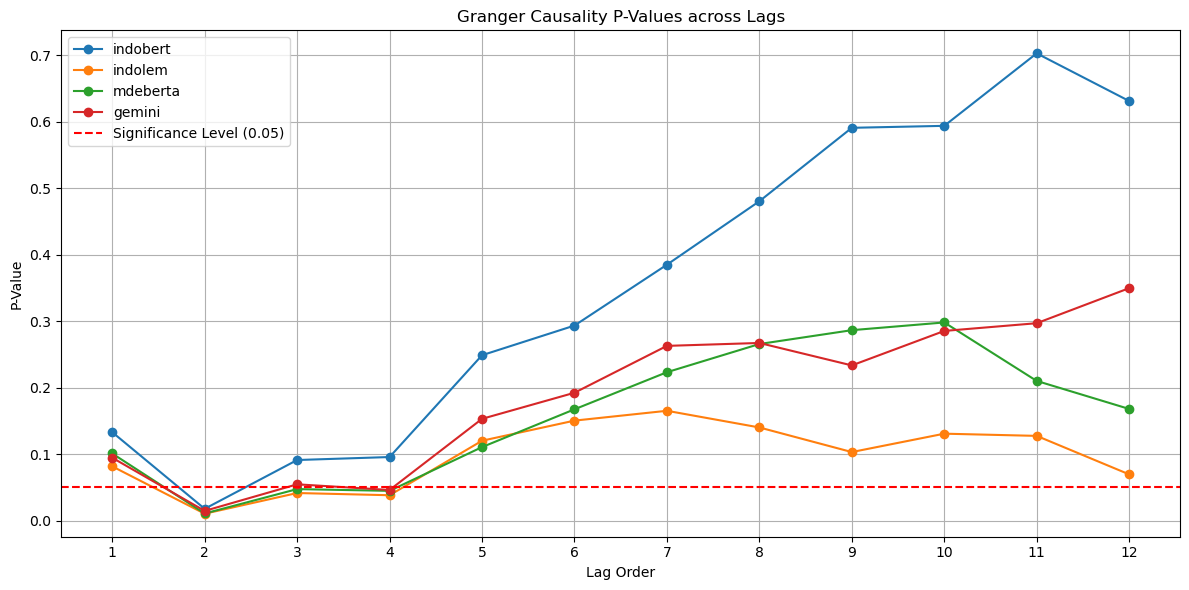

In [12]:
plt.figure(figsize=(12, 6))
for model in results.keys():
    plt.plot(range(1, MAX_LAG + 1), results[model], marker='o', label=model)

plt.axhline(0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.title("Granger Causality P-Values across Lags")
plt.xlabel("Lag Order")
plt.ylabel("P-Value")
plt.legend()
plt.grid(True)
plt.xticks(range(1, MAX_LAG + 1))
plt.tight_layout()

The script runs the grangercausalitytests for lags 1 through 12. It extracts the p-values for the Chi-square test at each lag. The "Best Lag" is determined by finding the lag order that minimizes the average p-value across all models.

The plot "Granger Causality P-Values across Lags" shows a clear trough at Lag 2. At this specific lag, the p-values for most models drop below the significance threshold (red dashed line at 0.05).

Past values of the sentiment index (specifically from 2 months prior) contain statistically significant information that helps predict future inflation rates. This validates the decision to use a 2-month lag in the final forecasting models.

# INSEI Index Creation 

- Raw
- Raw-Lagged
- Raw-Lagged with Causal Normalization (Expanding Window), Smoothing

In [27]:
LAG_MONTHS = best_lag_value # Based on Granger Causality results

for model in models:
    col_raw = f"insei_{model}_raw"
    
    # News(t) becomes Feature(t+2)
    insei_df[f"insei_{model}_lagged_raw"] = insei_df[f"insei_{model}_raw"].shift(LAG_MONTHS)

    # Expanding window normalization (Z-Score)
    # Min periods = 6 ensures we have enough data before calculating stats
    expanding_mean = insei_df[col_raw].expanding(min_periods=6).mean()
    expanding_std = insei_df[col_raw].expanding(min_periods=6).std()
    
    # Apply Z-score formula: (X - Mean) / Std
    insei_df[f"insei_{model}_norm"] = (insei_df[col_raw] - expanding_mean) / (expanding_std + 1e-8)
    
    # Fill initial NaNs (first 6 months) with 0 (Neutral)
    insei_df[f"insei_{model}_norm"] = insei_df[f"insei_{model}_norm"].fillna(0)
    
    # SMOOTHING: 3-Month Moving Average
    # This reduces noise from low-volume months (like 2017)
    insei_df[f"insei_{model}_smooth"] = insei_df[f"insei_{model}_norm"].rolling(window=3).mean().fillna(0)
    
    # LAGGING: Shift data FORWARD by 2 months
    # News(t) becomes Feature(t+2) after process
    insei_df[f"insei_{model}_lagged"] = insei_df[f"insei_{model}_smooth"].shift(LAG_MONTHS)

    # Scale to Index (50 = Neutral) for readability/plotting
    insei_df[f"insei_{model}_final"] = 50 + (insei_df[f"insei_{model}_lagged"] * 10)

# Drop rows where lag created NaNs (First 2 months)
insei_df = insei_df.dropna().reset_index(drop=True)
print(f"Smoothing and Lagging (2 months) Complete. Shape: {insei_df.shape}")

Smoothing and Lagging (2 months) Complete. Shape: (100, 25)


In [ ]:
# Merge on year_month
final_df = pd.merge(insei_df, cpi_clean, on="year_month", how="inner")

# Convert year_month back to string/datetime for saving
final_df["year_month_str"] = final_df["year_month"].astype(str)
final_df["year_month_dt"] = final_df["year_month"].dt.to_timestamp()

# Save
final_df.to_csv("insei_all_model_raw_granger_fullmodif.csv", index=False)

In [29]:
final_df.head()

,year_month,insei_indobert_raw,insei_indolem_raw,insei_mdeberta_raw,insei_gemini_raw,insei_indobert_norm,insei_indobert_smooth,insei_indobert_lagged,insei_indobert_final,insei_indolem_norm,...,insei_gemini_smooth,insei_gemini_lagged,insei_gemini_final,insei_indobert_lagged_raw,insei_indolem_lagged_raw,insei_mdeberta_lagged_raw,insei_gemini_lagged_raw,Rate,year_month_str,year_month_dt
0,2017-07,-0.078912,0.011876,-0.050584,0.048780,0.00000,0.000000,0.0,50.0,0.000000,...,0.000000,0.0,50.0,0.018024,0.264608,0.222023,0.230769,0.22,2017-07,2017-07-01
1,2017-08,-0.052705,0.018444,-0.051758,0.040000,0.00000,0.000000,0.0,50.0,0.000000,...,0.000000,0.0,50.0,0.098984,0.229115,0.142892,0.296296,-0.07,2017-08,2017-08-01
2,2017-09,0.044486,0.115167,0.095657,0.250000,0.00000,0.000000,0.0,50.0,0.000000,...,0.000000,0.0,50.0,-0.078912,0.011876,-0.050584,0.048780,0.13,2017-09,2017-09-01
3,2017-10,-0.026432,0.043418,0.026158,0.081633,-0.40897,-0.136323,0.0,50.0,-0.639696,...,-0.223749,0.0,50.0,-0.052705,0.018444,-0.051758,0.040000,0.01,2017-10,2017-10-01
4,2017-11,-0.124479,0.053617,-0.018199,0.163265,-1.39928,-0.602750,0.0,50.0,-0.500887,...,-0.209011,0.0,50.0,0.044486,0.115167,0.095657,0.250000,0.20,2017-11,2017-11-01


The final step prepares the data for the forecasting models by applying statistical transformations based on the Granger test results.

Code Logic:
1. Z-Score Normalization: To ensure stationarity and comparability, an expanding window standardization is applied.$$INSEI_t = \frac{INSEI_t^{raw} - \mu_t}{\sigma_t}$$Where $\mu_t$ and $\sigma_t$ are the mean and standard deviation of the expanding window up to time $t$.
2. Smoothing: A 3-month moving average is applied to reduce high-frequency noise inherent in news volume data.
3. Lagging: The data is shifted forward by the optimal 2 months identified in the Granger test. This aligns the sentiment at time $t$ with the inflation rate at time $t+2$.
4. Scaling: The final index is scaled to a baseline of 50 (Neutral), where values $>50$ indicate inflationary pressure and $<50$ indicate deflationary pressure.



# Plotting

### Raw

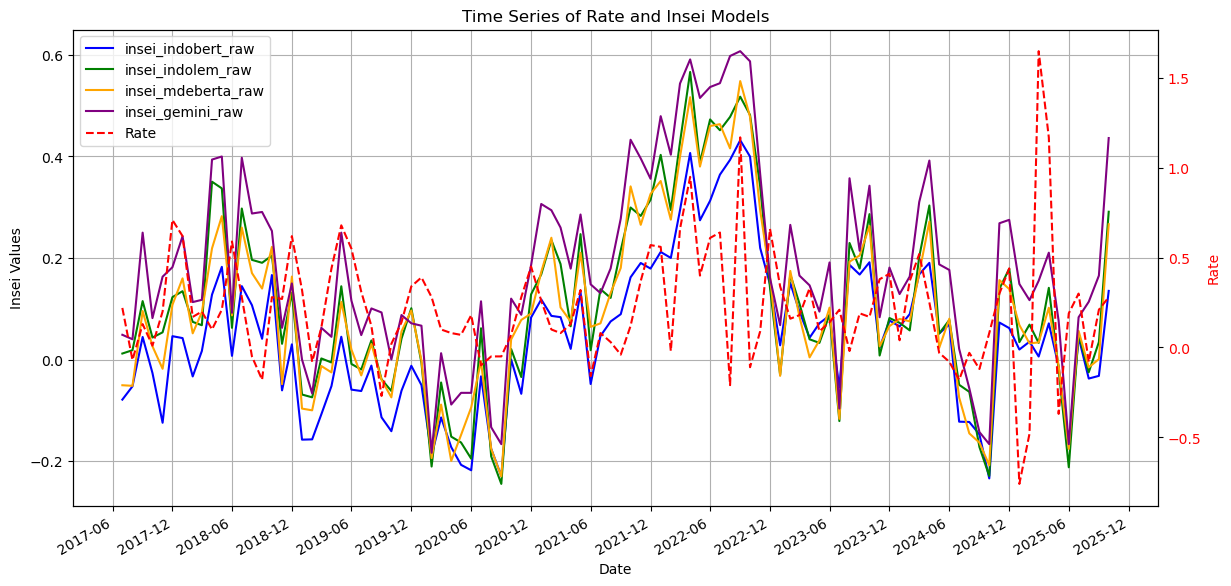

In [30]:
# Convert year_month_dt to datetime
final_df['year_month_dt'] = pd.to_datetime(final_df['year_month_dt'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the insei columns on the primary y-axis
ax1.plot(final_df['year_month_dt'], final_df['insei_indobert_raw'], label='insei_indobert_raw', color='blue')
ax1.plot(final_df['year_month_dt'], final_df['insei_indolem_raw'], label='insei_indolem_raw', color='green')
ax1.plot(final_df['year_month_dt'], final_df['insei_mdeberta_raw'], label='insei_mdeberta_raw', color='orange')
ax1.plot(final_df['year_month_dt'], final_df['insei_gemini_raw'], label='insei_gemini_raw', color='purple')

ax1.set_xlabel('Date')
ax1.set_ylabel('Insei Values', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Rate column
ax2 = ax1.twinx()
ax2.plot(final_df['year_month_dt'], final_df['Rate'], label='Rate', color='red', linestyle='--')
ax2.set_ylabel('Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Time Series of Rate and Insei Models')
ax1.grid(True)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

### Raw-Lagged

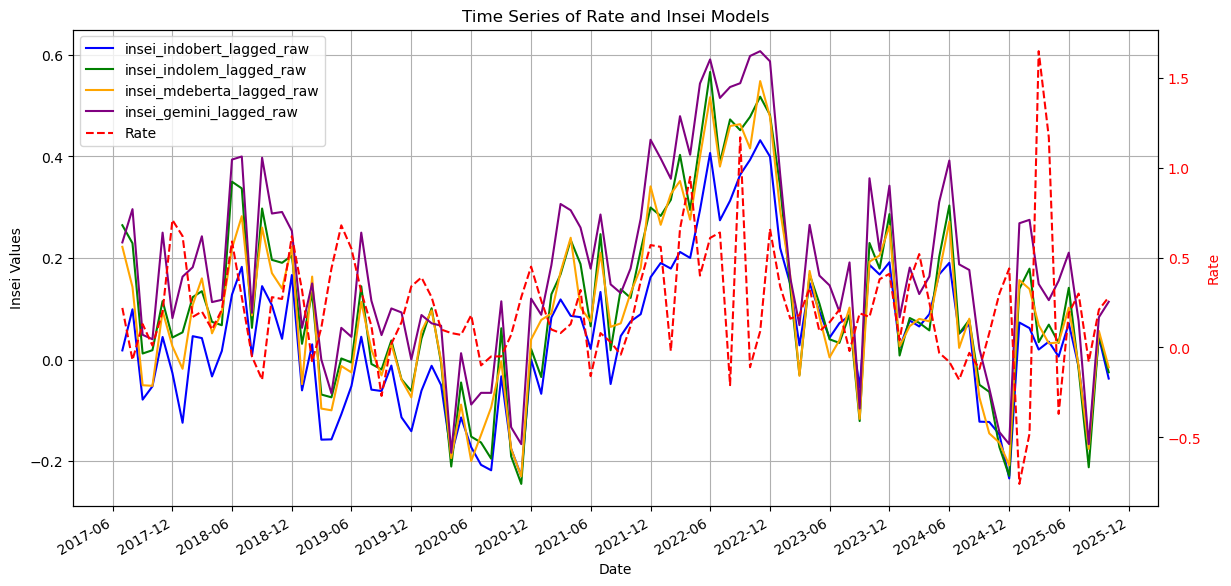

In [32]:
# Convert year_month_dt to datetime
final_df['year_month_dt'] = pd.to_datetime(final_df['year_month_dt'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the insei columns on the primary y-axis
ax1.plot(final_df['year_month_dt'], final_df['insei_indobert_lagged_raw'], label='insei_indobert_lagged_raw', color='blue')
ax1.plot(final_df['year_month_dt'], final_df['insei_indolem_lagged_raw'], label='insei_indolem_lagged_raw', color='green')
ax1.plot(final_df['year_month_dt'], final_df['insei_mdeberta_lagged_raw'], label='insei_mdeberta_lagged_raw', color='orange')
ax1.plot(final_df['year_month_dt'], final_df['insei_gemini_lagged_raw'], label='insei_gemini_lagged_raw', color='purple')

ax1.set_xlabel('Date')
ax1.set_ylabel('Insei Values', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Rate column
ax2 = ax1.twinx()
ax2.plot(final_df['year_month_dt'], final_df['Rate'], label='Rate', color='red', linestyle='--')
ax2.set_ylabel('Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Time Series of Rate and Insei Models')
ax1.grid(True)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

### Full Processed

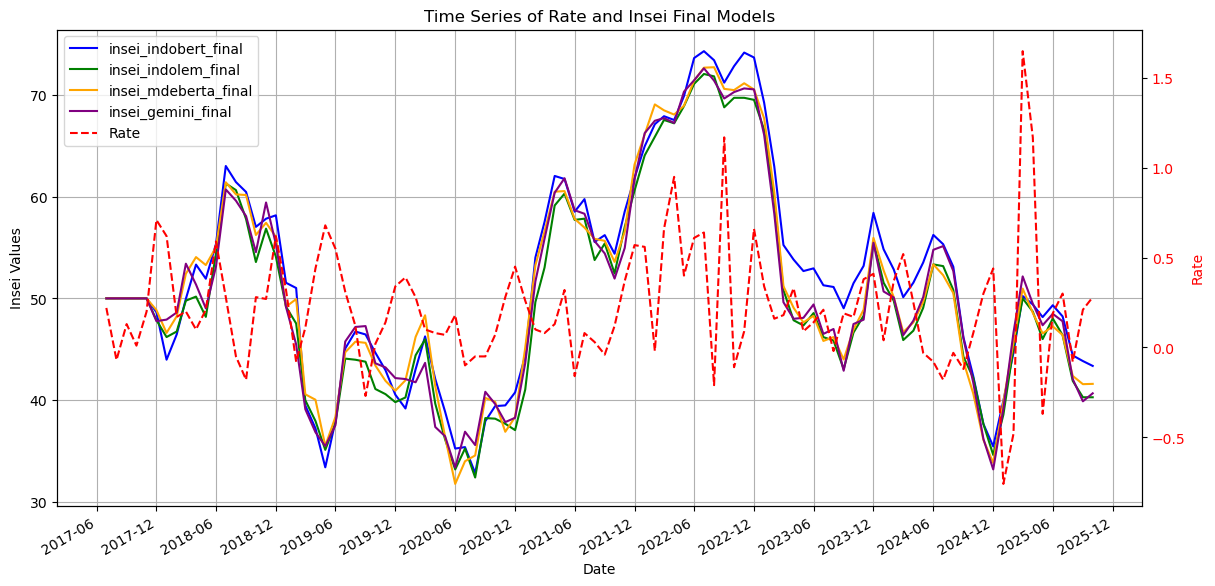

In [42]:
# Convert year_month_dt to datetime
final_df['year_month_dt'] = pd.to_datetime(final_df['year_month_dt'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the insei columns on the primary y-axis
ax1.plot(final_df['year_month_dt'], final_df['insei_indobert_final'], label='insei_indobert_final', color='blue')
ax1.plot(final_df['year_month_dt'], final_df['insei_indolem_final'], label='insei_indolem_final', color='green')
ax1.plot(final_df['year_month_dt'], final_df['insei_mdeberta_final'], label='insei_mdeberta_final', color='orange')
ax1.plot(final_df['year_month_dt'], final_df['insei_gemini_final'], label='insei_gemini_final', color='purple')

ax1.set_xlabel('Date')
ax1.set_ylabel('Insei Values', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for the Rate column
ax2 = ax1.twinx()
ax2.plot(final_df['year_month_dt'], final_df['Rate'], label='Rate', color='red', linestyle='--')
ax2.set_ylabel('Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Time Series of Rate and Insei Final Models')
ax1.grid(True)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

The time-series plot visualizes the final aligned data. The Sentiment Indices (solid lines) hover around the neutral 50 mark but show clear cyclical trends. The Inflation Rate (red dashed line) is much more volatile. 

The plot illustrates that while the sentiment indices smooth out month-to-month noise, they effectively capture broader expansions and contractions in economic sentiment, serving as a stable trend signal for the more volatile target variable.

# Correlation

### Raw

In [40]:
correlation_matrix_raw = final_df[['Rate', 'insei_indobert_raw', 'insei_indolem_raw', 'insei_mdeberta_raw', 'insei_gemini_raw']].corr()
correlation_matrix_raw

,Rate,insei_indobert_raw,insei_indolem_raw,insei_mdeberta_raw,insei_gemini_raw
Rate,1.000000,0.308983,0.304177,0.331930,0.284792
insei_indobert_raw,0.308983,1.000000,0.953237,0.958016,0.941960
insei_indolem_raw,0.304177,0.953237,1.000000,0.978290,0.978664
insei_mdeberta_raw,0.331930,0.958016,0.978290,1.000000,0.969957
insei_gemini_raw,0.284792,0.941960,0.978664,0.969957,1.000000


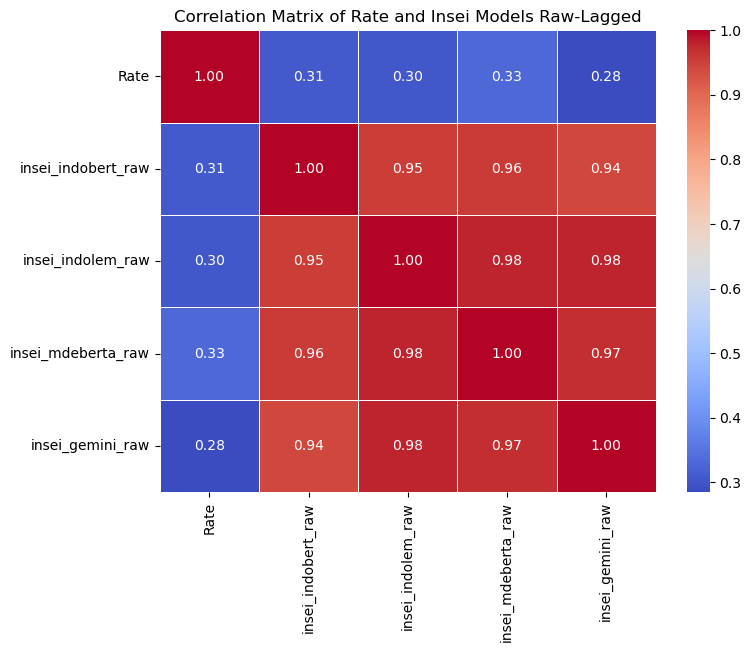

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_raw, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Rate and Insei Models Raw-Lagged')
plt.show()

### Raw-Lagged

In [ ]:
correlation_matrix_lagged_raw = final_df[['Rate', 'insei_indobert_lagged_raw', 'insei_indolem_lagged_raw', 'insei_mdeberta_lagged_raw', 'insei_gemini_lagged_raw']].corr()
correlation_matrix_lagged_raw

,Rate,insei_indobert_lagged_raw,insei_indolem_lagged_raw,insei_mdeberta_lagged_raw,insei_gemini_lagged_raw
Rate,1.000000,0.172704,0.176094,0.179732,0.161348
insei_indobert_lagged_raw,0.172704,1.000000,0.947863,0.954187,0.943861
insei_indolem_lagged_raw,0.176094,0.947863,1.000000,0.977372,0.977581
insei_mdeberta_lagged_raw,0.179732,0.954187,0.977372,1.000000,0.969662
insei_gemini_lagged_raw,0.161348,0.943861,0.977581,0.969662,1.000000


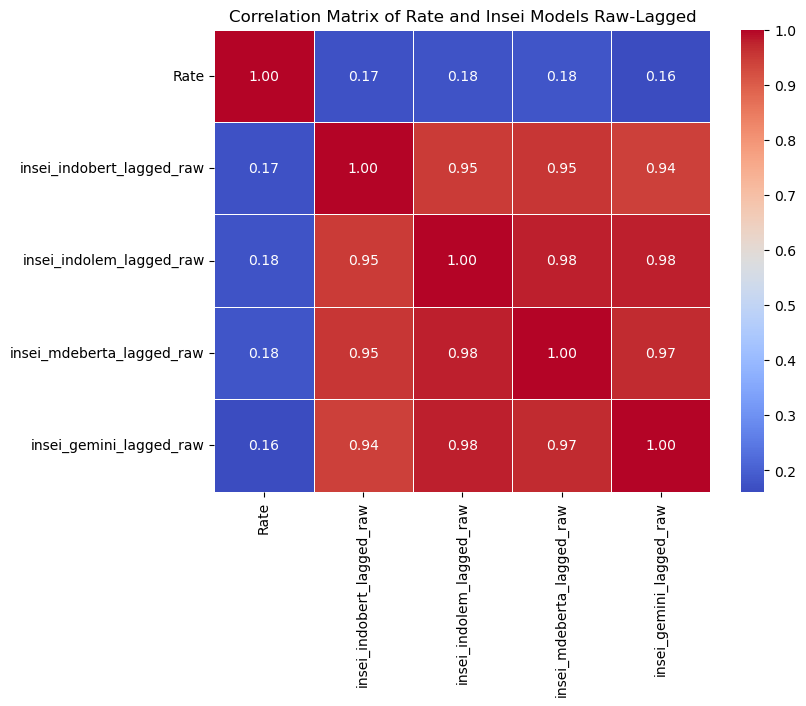

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_lagged_raw, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Rate and Insei Models Raw-Lagged')
plt.show()

### Full Processed

In [18]:
correlation_matrix = final_df[['Rate', 'insei_indobert_final', 'insei_indolem_final', 'insei_mdeberta_final', 'insei_gemini_final']].corr()
correlation_matrix

,Rate,insei_indobert_final,insei_indolem_final,insei_mdeberta_final,insei_gemini_final
Rate,1.000000,0.165818,0.19913,0.194457,0.197250
insei_indobert_final,0.165818,1.000000,0.98022,0.979460,0.971206
insei_indolem_final,0.199130,0.980220,1.00000,0.991820,0.990790
insei_mdeberta_final,0.194457,0.979460,0.99182,1.000000,0.986479
insei_gemini_final,0.197250,0.971206,0.99079,0.986479,1.000000


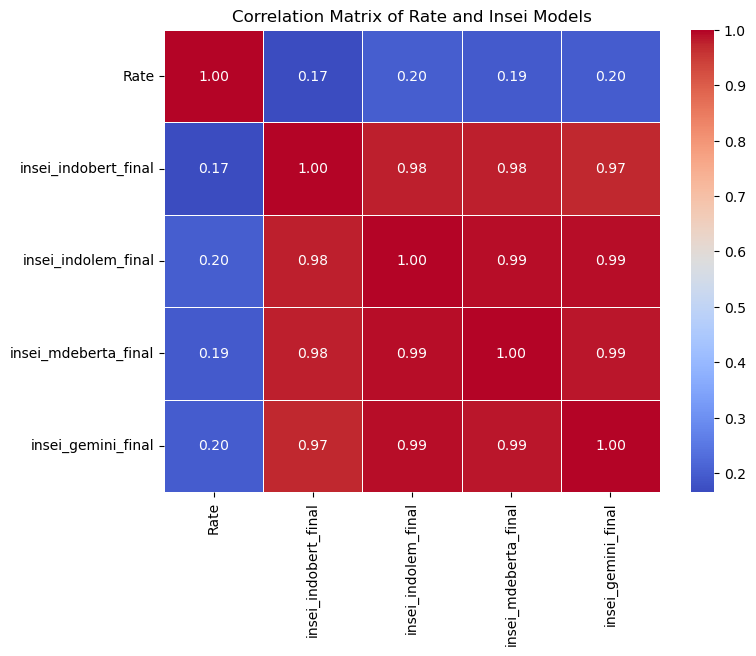

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Rate and Insei Models')
plt.show()

There is an extremely high correlation (approximately 0.97 to 0.99) between all four NLP models (IndoBERT, IndoLEM, mDeBERTa, Gemini). 

This indicates that despite the differences in model architecture (BERT-based vs. LLM-based), they are all capturing the exact same sentiment signals from the underlying text data.

But, The correlation between the Sentiment Index (insei) and the Rate is positive but relatively weak, ranging from 0.16 to 0.20.

A correlation of ~0.2 suggests that while there is a slight tendency for the Rate to increase when sentiment improves (values > 50) and decrease when sentiment worsens, the sentiment index alone is not a strong linear predictor of the Rate in this specific lag setup.

## Rolling Correlation Rate & INSEI Gemini

### Raw

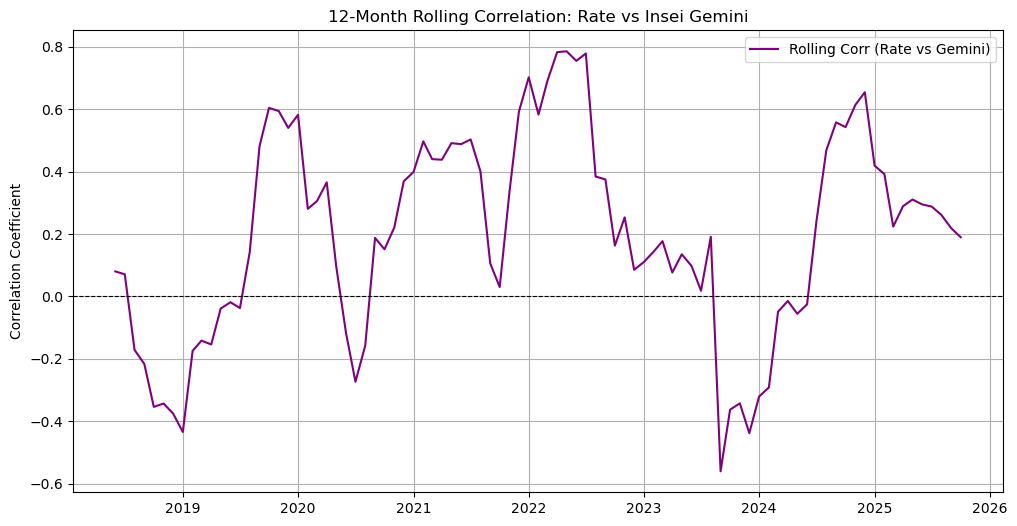

In [50]:
# Calculate rolling correlation (12-month window)
rolling_corr = final_df['Rate'].rolling(window=12).corr(final_df['insei_gemini_raw'])

# Plot rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(final_df['year_month_dt'], rolling_corr, color='purple', label='Rolling Corr (Rate vs Gemini)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('12-Month Rolling Correlation: Rate vs Insei Gemini')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.legend()

### Raw-Lagged

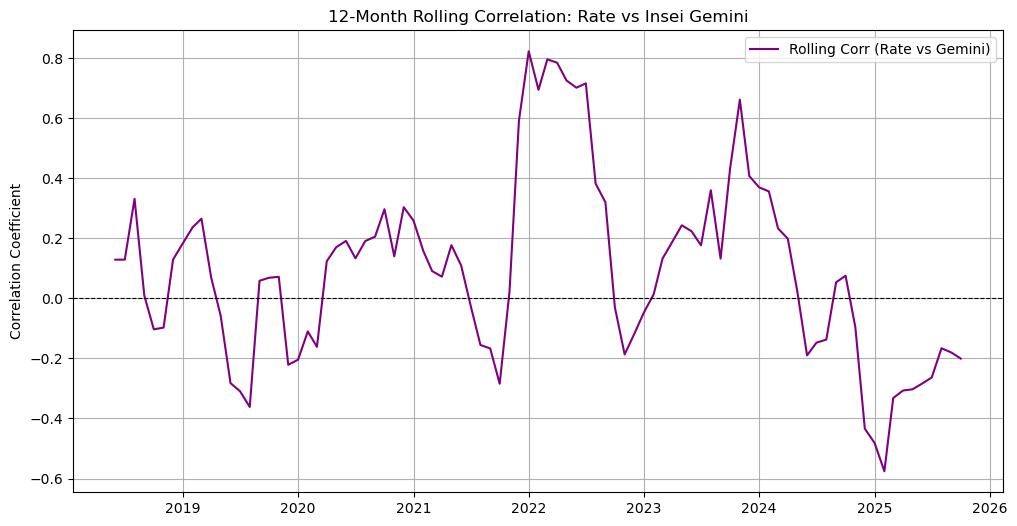

In [49]:
# Calculate rolling correlation (12-month window)
rolling_corr = final_df['Rate'].rolling(window=12).corr(final_df['insei_gemini_lagged_raw'])

# Plot rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(final_df['year_month_dt'], rolling_corr, color='purple', label='Rolling Corr (Rate vs Gemini)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('12-Month Rolling Correlation: Rate vs Insei Gemini')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.legend()

### Full Processed

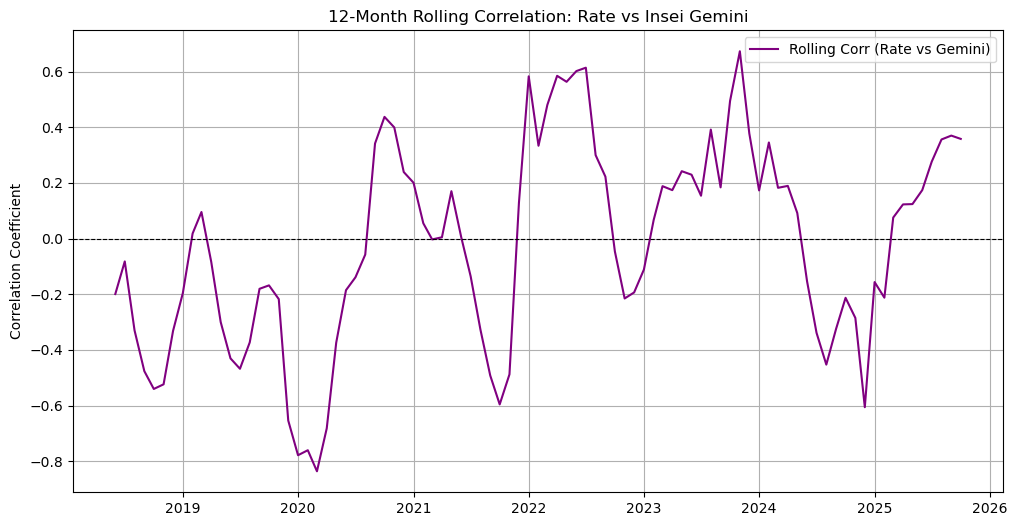

In [48]:
# Calculate rolling correlation (12-month window)
rolling_corr = final_df['Rate'].rolling(window=12).corr(final_df['insei_gemini_final'])

# Plot rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(final_df['year_month_dt'], rolling_corr, color='purple', label='Rolling Corr (Rate vs Gemini)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('12-Month Rolling Correlation: Rate vs Insei Gemini')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.legend()

The 12-month rolling correlation plot reveals that the relationship between Sentiment and Inflation is non-stationary. There are specific periods where the correlation spikes significantly (e.g., > 0.6), suggesting that the index becomes highly predictive during specific economic regimes (likely crises or shocks), while decoupling during periods of stability. This insight suggests that the index is particularly valuable as an "Early Warning System" for economic shocks.

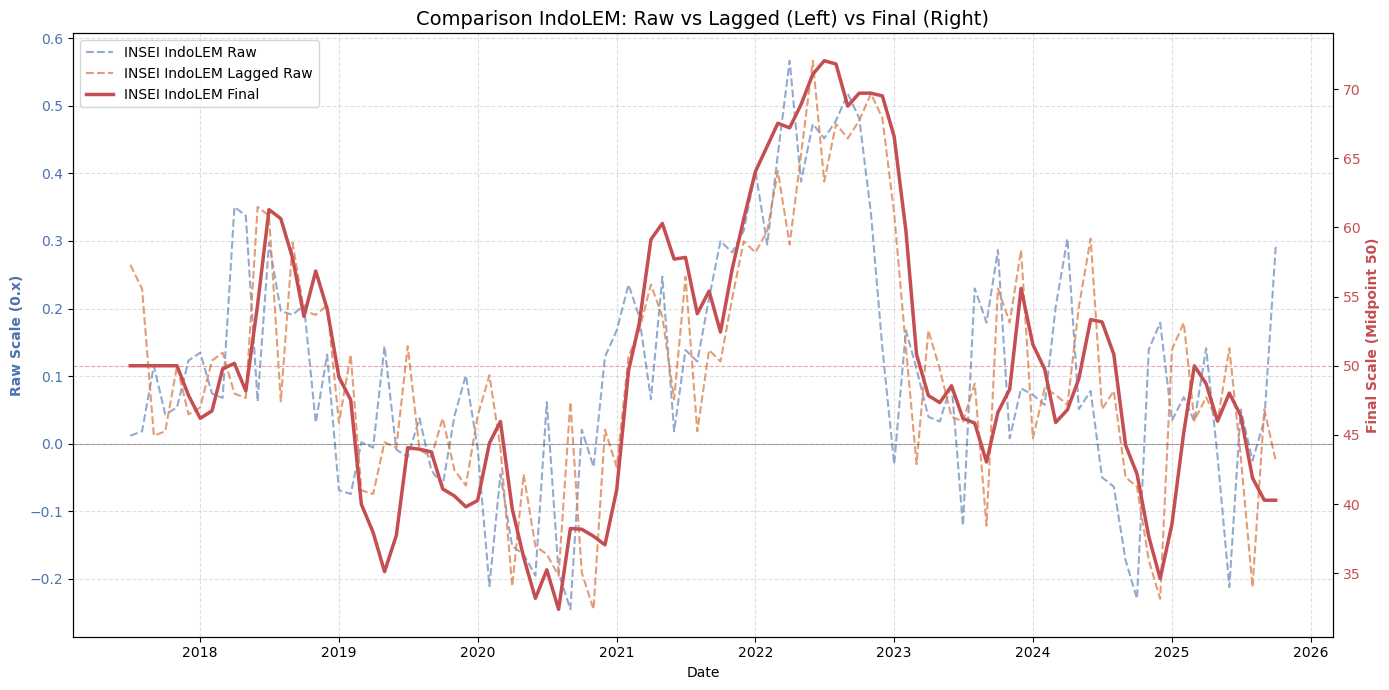

In [62]:
# --- CHOOSE YOUR PALETTE HERE ---
color_raw = '#4C72B0'    # Muted Teal
color_lagged = '#DD8452' # Soft Amber
color_final = '#C44E52'  # Dust Rose
# -------------------------------

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Raw Scale (0.x)', color=color_raw, fontweight='bold')
ax1.plot(final_df['year_month_dt'], final_df['insei_indolem_raw'], 
         label='INSEI IndoLEM Raw', color=color_raw, alpha=0.6, linestyle='--')
ax1.plot(final_df['year_month_dt'], final_df['insei_indolem_lagged_raw'], 
         label='INSEI IndoLEM Lagged Raw', color=color_lagged, alpha=0.8, linestyle = "--")
ax1.tick_params(axis='y', labelcolor=color_raw)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='-', alpha=0.3)

ax2 = ax1.twinx() 

ax2.set_ylabel('Final Scale (Midpoint 50)', color=color_final, fontweight='bold')
ax2.plot(final_df['year_month_dt'], final_df['insei_indolem_final'], 
         label='INSEI IndoLEM Final', color=color_final, linewidth=2.5) # Removed dash for emphasis
ax2.tick_params(axis='y', labelcolor=color_final)
ax2.axhline(50, color=color_final, linewidth=0.8, linestyle='--', alpha=0.5) 

# Rest of your styling...
plt.title('Comparison IndoLEM: Raw vs Lagged (Left) vs Final (Right)', fontsize=14)
ax1.grid(True, which='both', linestyle='--', alpha=0.4)

# Menggabungkan legend dari kedua axis
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()